In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import numpy as np
import pandas as pd

from os.path import join

import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

%matplotlib inline

In [3]:
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
scores = pd.read_excel(join(eCON,'STAIscores/scores.xlsx'))
scores.rename(columns={'SCORING':'TRAIT'},inplace=True)
scores.drop(columns=['PAIR SCORE'],inplace=True)
scores['SubID'] = scores['SubID'].apply(lambda name: ''.join(name.strip().split("_")))

# Brain-behavior analysis

In [4]:
# Choose an roi from the list above
roi = 'rBNST'

In [5]:
# Load the data that contains shock betas for all participants
beta_df = pd.read_csv('Individual_betas_from_ROI_analysis_S.csv')

In [6]:
# Some dataframe manipulations to put all the information like shock betas, behavioral scores within a single df

tmp_df = beta_df[beta_df['ROI']==roi][['Pair','Subject','Group','shock']].reset_index(drop=True)
tmp_df.rename(columns={'shock':'shock: {}'.format(roi)},inplace=True)

# Pivoting creates hirarchical columns which convert all objects to non-null objects
pair_info_df = tmp_df.pivot(columns='Group',values=['Subject','shock: {}'.format(roi)],index='Pair')

# Adding a column with yoked-difference
pair_info_df[('shock: {}'.format(roi),'uncon-con')] = pair_info_df.loc[:,('shock: {}'.format(roi),'uncontrol')] - pair_info_df.loc[:,('shock: {}'.format(roi),'control')]
pair_info_df.rename(columns={'Subject':'SubID'},inplace=True)


In [7]:
new_score_df = pd.DataFrame()
for i,row in pair_info_df.iterrows():
    conTrait = scores[scores['SubID'] == row[('SubID','control')]]['TRAIT'].values[0]
    unconTrait = scores[scores['SubID'] == row[('SubID','uncontrol')]]['TRAIT'].values[0]
    
    conState = scores[scores['SubID'] == row[('SubID','control')]]['STATE'].values[0]
    unconState = scores[scores['SubID'] == row[('SubID','uncontrol')]]['STATE'].values[0]
    
    tmp_df = pd.DataFrame([i,row[('SubID','uncontrol')],row[('SubID','control')],
                           unconTrait,conTrait,unconTrait-conTrait,np.mean([unconTrait,conTrait]),
                           unconState,conState,unconState-conState,np.mean([unconState,conState])],
                          index=['Pair',('SubID','uncontrol'),('SubID','control'),
                                  ('TRAIT','uncontrol'),('TRAIT','control'),('TRAIT','uncon-con'),('TRAIT','mean'),
                                  ('STATE','uncontrol'),('STATE','control'),('STATE','uncon-con'),('STATE','mean')]).T
    
    new_score_df = pd.concat([new_score_df,tmp_df],axis=0)
    
new_score_df.set_index('Pair',inplace=True)


new_score_df.columns = pd.MultiIndex.from_tuples(new_score_df.columns)
final_df = pair_info_df.merge(new_score_df,left_on=[('SubID','uncontrol'), ('SubID','control')],right_on=[('SubID','uncontrol'), ('SubID','control')])

In [8]:
for col in ['shock: {}'.format(roi),'TRAIT','STATE']:
    final_df[col] = final_df[col].astype(float)

In [13]:
final_df.head()

SubID           shock: rBNST                         TRAIT          \
Group control uncontrol      control uncontrol uncon-con uncontrol control   
0      CON001    CON031     0.608696  1.162880  0.554184      27.0    27.0   
1      CON002    CON021     0.770967  0.097088 -0.673879      36.0    27.0   
2      CON003    CON022     0.587932 -0.053047 -0.640979      37.0    36.0   
3      CON004    CON030     0.179488  0.342934  0.163446      24.0    21.0   
4      CON005    CON023     0.577107  0.766328  0.189221      33.0    33.0   

                          STATE                          
Group uncon-con  mean uncontrol control uncon-con  mean  
0           0.0  27.0      22.0    24.0      -2.0  23.0  
1           9.0  31.5      30.0    26.0       4.0  28.0  
2           1.0  36.5      29.0    26.0       3.0  27.5  
3           3.0  22.5      20.0    21.0      -1.0  20.5  
4           0.0  33.0      32.0    26.0       6.0  29.0

In [20]:
uncon_lr_df = final_df[
    [
        ('shock: {}'.format(roi),'uncontrol'),
        ('TRAIT','uncontrol'),('STATE','uncontrol'),
    ]
]

uncon_lr_df.head()

,shock: rBNST,TRAIT,STATE
Group,uncontrol,uncontrol,uncontrol
0,1.162880,27.0,22.0
1,0.097088,36.0,30.0
2,-0.053047,37.0,29.0
3,0.342934,24.0,20.0
4,0.766328,33.0,32.0


## Corrleations and VIFs

/home/climbach/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


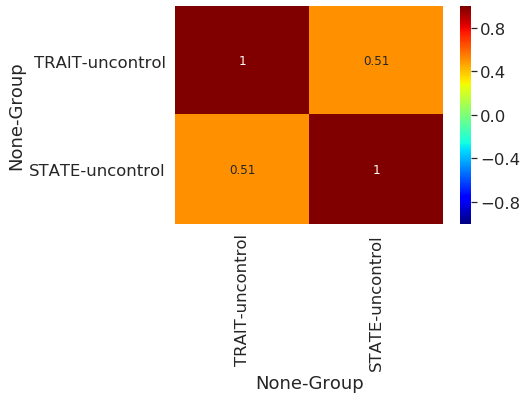

In [21]:
sns.heatmap(uncon_lr_df.drop(columns='shock: {}'.format(roi)).corr(),vmin=-1,vmax=1,cmap='jet',annot=True,annot_kws={'size':12})

In [22]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [23]:
uncon_lr_df.columns

MultiIndex(levels=[['STATE', 'SubID', 'TRAIT', 'shock: rBNST'], ['control', 'mean', 'uncon-con', 'uncontrol']],
           codes=[[3, 2, 0], [3, 3, 3]],
           names=[None, 'Group'])

In [25]:
y = uncon_lr_df[('shock: {}'.format(roi),'uncontrol')]
X = uncon_lr_df[[('TRAIT','uncontrol'),('STATE','uncontrol')]]

ss = StandardScaler()
X_norm = pd.DataFrame(ss.fit_transform(X),columns=X.columns)

X_norm = sm.add_constant(X_norm)
model = sm.OLS(y,X_norm)
results = model.fit()

/home/climbach/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Linear regression OLS:
- y: shock beta
- X: TRAIT (mean and uncon-con), STATE (mena and uncon-con)

In [28]:
X_norm.head()

,const,"(TRAIT, uncontrol)","(STATE, uncontrol)"
0,1.0,-1.034208,-1.048691
1,1.0,0.126897,-0.081279
2,1.0,0.255908,-0.202205
3,1.0,-1.421243,-1.290544
4,1.0,-0.260138,0.160575


In [27]:
print(results.summary())

                                  OLS Regression Results                                 
Dep. Variable:     ('shock: rBNST', 'uncontrol')   R-squared:                       0.034
Model:                                       OLS   Adj. R-squared:                  0.001
Method:                            Least Squares   F-statistic:                     1.029
Date:                           Fri, 27 Mar 2020   Prob (F-statistic):              0.364
Time:                                   13:48:07   Log-Likelihood:                -24.479
No. Observations:                             61   AIC:                             54.96
Df Residuals:                                 58   BIC:                             61.29
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

Text(0.5, 1.0, 'Real vs. Predicted')

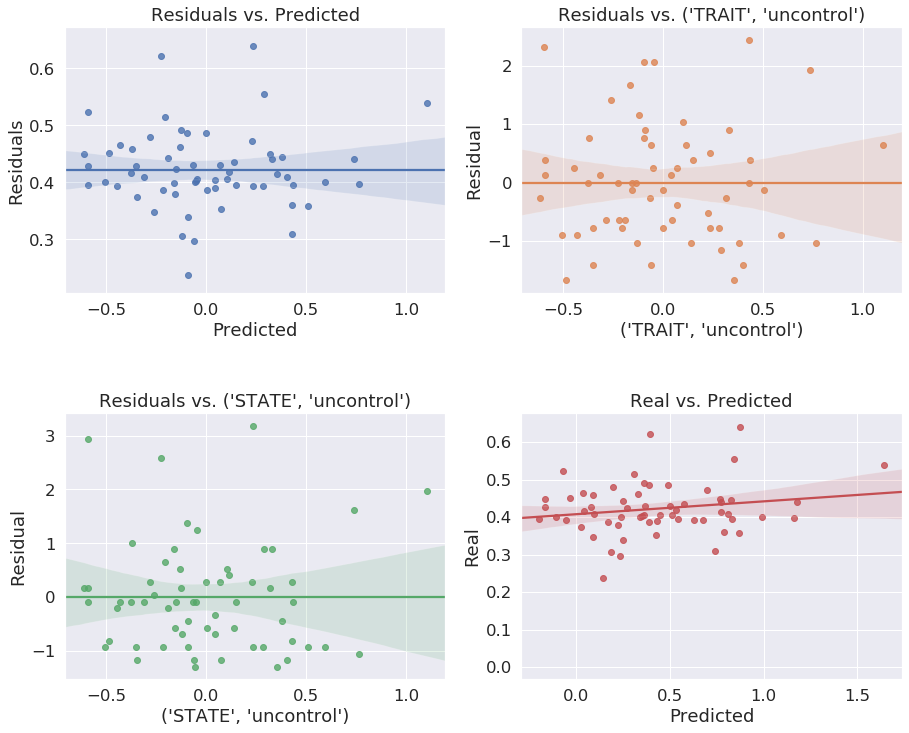

In [32]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,12),sharey=False)
fig.subplots_adjust(wspace=None, hspace=0.45)

axes = axes.flatten()

sns.regplot(results.resid,results.fittedvalues,ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs. Predicted')

sns.regplot(results.resid,X_norm.iloc[:,1],ax=axes[1])
axes[1].set_xlabel('{}'.format(X_norm.columns[1]))
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals vs. {}'.format(X_norm.columns[1]))

sns.regplot(results.resid,X_norm.iloc[:,2],ax=axes[2])
axes[2].set_xlabel('{}'.format(X_norm.columns[2]))
axes[2].set_ylabel('Residual')
axes[2].set_title('Residuals vs. {}'.format(X_norm.columns[2]))

sns.regplot(y,results.fittedvalues,ax=axes[3])
axes[3].set_xlabel('Predicted')
axes[3].set_ylabel('Real')
axes[3].set_title('Real vs. Predicted')


# Controls

In [34]:
con_lr_df = final_df[
    [
        ('shock: {}'.format(roi),'control'),
        ('TRAIT','control'),('STATE','control'),
    ]
]

con_lr_df.head()

,shock: rBNST,TRAIT,STATE
Group,control,control,control
0,0.608696,27.0,24.0
1,0.770967,27.0,26.0
2,0.587932,36.0,26.0
3,0.179488,21.0,21.0
4,0.577107,33.0,26.0


## Corrleations and VIFs

/home/climbach/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


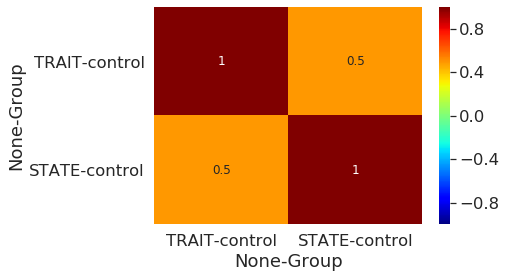

In [35]:
sns.heatmap(con_lr_df.drop(columns='shock: {}'.format(roi)).corr(),vmin=-1,vmax=1,cmap='jet',annot=True,annot_kws={'size':12})

In [36]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [37]:
con_lr_df.columns

MultiIndex(levels=[['STATE', 'SubID', 'TRAIT', 'shock: rBNST'], ['control', 'mean', 'uncon-con', 'uncontrol']],
           codes=[[3, 2, 0], [0, 0, 0]],
           names=[None, 'Group'])

In [38]:
y = con_lr_df[('shock: {}'.format(roi),'control')]
X = con_lr_df[[('TRAIT','control'),('STATE','control')]]

ss = StandardScaler()
X_norm = pd.DataFrame(ss.fit_transform(X),columns=X.columns)

X_norm = sm.add_constant(X_norm)
model = sm.OLS(y,X_norm)
results = model.fit()

/home/climbach/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Linear regression OLS:
- y: shock beta
- X: TRAIT (mean and uncon-con), STATE (mena and uncon-con)

In [39]:
X_norm.head()

,const,"(TRAIT, control)","(STATE, control)"
0,1.0,-0.945600,-0.873076
1,1.0,-0.945600,-0.618255
2,1.0,0.131442,-0.618255
3,1.0,-1.663628,-1.255307
4,1.0,-0.227572,-0.618255


In [40]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     ('shock: rBNST', 'control')   R-squared:                       0.070
Model:                                     OLS   Adj. R-squared:                  0.038
Method:                          Least Squares   F-statistic:                     2.195
Date:                         Fri, 27 Mar 2020   Prob (F-statistic):              0.120
Time:                                 13:53:36   Log-Likelihood:                -19.038
No. Observations:                           61   AIC:                             44.08
Df Residuals:                               58   BIC:                             50.41
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Text(0.5, 1.0, 'Real vs. Predicted')

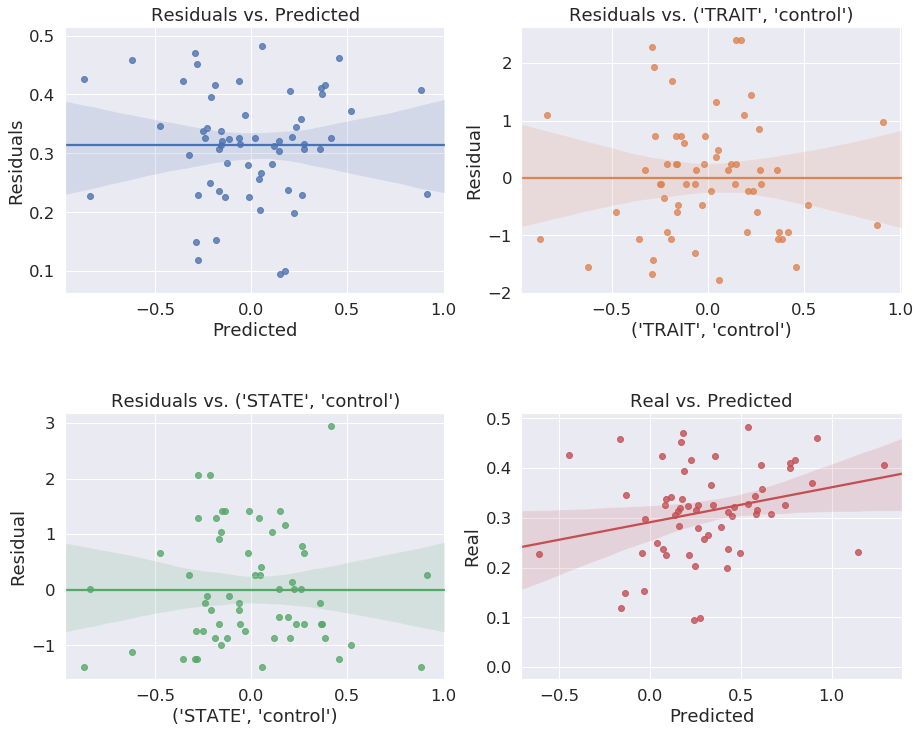

In [41]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,12),sharey=False)
fig.subplots_adjust(wspace=None, hspace=0.45)

axes = axes.flatten()

sns.regplot(results.resid,results.fittedvalues,ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs. Predicted')

sns.regplot(results.resid,X_norm.iloc[:,1],ax=axes[1])
axes[1].set_xlabel('{}'.format(X_norm.columns[1]))
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals vs. {}'.format(X_norm.columns[1]))

sns.regplot(results.resid,X_norm.iloc[:,2],ax=axes[2])
axes[2].set_xlabel('{}'.format(X_norm.columns[2]))
axes[2].set_ylabel('Residual')
axes[2].set_title('Residuals vs. {}'.format(X_norm.columns[2]))

sns.regplot(y,results.fittedvalues,ax=axes[3])
axes[3].set_xlabel('Predicted')
axes[3].set_ylabel('Real')
axes[3].set_title('Real vs. Predicted')


In [43]:
uncon_lr_df.corr(method='spearman')

,,shock: rBNST,TRAIT,STATE
,Group,uncontrol,uncontrol,uncontrol
,Group,,,
shock: rBNST,uncontrol,1.000000,-0.089908,0.066727
TRAIT,uncontrol,-0.089908,1.000000,0.526327
STATE,uncontrol,0.066727,0.526327,1.000000


In [44]:
con_lr_df.corr(method='spearman')

,,shock: rBNST,TRAIT,STATE
,Group,control,control,control
,Group,,,
shock: rBNST,control,1.000000,-0.242692,-0.178022
TRAIT,control,-0.242692,1.000000,0.568445
STATE,control,-0.178022,0.568445,1.000000
